In [1]:
import os
from typing import Iterable

import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.special import logit, expit

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import matplotlib.dates as mdates
from matplotlib import colormaps

In [2]:
# Filepathing constants
BEST_PARAMS_FOLDER = "best_params"
PLOTS_FOLDER = "plots"
BEST_GUESS_PARAMS_FILE_FORMAT = "Homework_3_dataset_{}_lybbert.csv"

CASE_DATA_FILE_FORMAT = "Homework_3_dataset_{}.csv"
RELATIVE_PATH_TO_DATA = "../data/"


def load_obs_data(dataset_num: int) -> pd.DataFrame:
    """
    Load the observed cases from a CSV file.

    :param dataset_num: The dataset number to load.

    :return: A DataFrame containing the observed cases.
    """
    filepath = os.path.join(RELATIVE_PATH_TO_DATA, CASE_DATA_FILE_FORMAT.format(dataset_num))
    df = pd.read_csv(filepath)
    obs_data = df.obs_data.values
    return obs_data


def save_best_params(best_params: Iterable, dataset_num: int) -> None:
    """
    Save the best parameters to a CSV file.

    :param best_params: The best parameters to save.
    :param dataset_num: The dataset number to include in the filename.

    :return: A DataFrame containing the best parameters.
    """
    filename = os.path.join(
        BEST_PARAMS_FOLDER,
        BEST_GUESS_PARAMS_FILE_FORMAT.format(dataset_num)
    )
    temp_df = pd.DataFrame(
        [["value"] + best_params],
        columns=["parameter", "S_0", "beta", "gamma", "rho"],
    ).set_index("parameter").T
    temp_df.to_csv(filename, index_label="parameter")


In [3]:
# --- Constants ---
POPULATION = 1000
NUM_YEARS = 1
YEAR_START = 2000
YEAR_END = YEAR_START + NUM_YEARS - 1
DATE_START = pd.to_datetime(f"{YEAR_START}-01-01")
DATE_END = pd.to_datetime(f"{YEAR_END}-12-31")
TIME_STEP = "W"
DATES = pd.date_range(start=DATE_START, end=DATE_END, freq=TIME_STEP)

# Define DT
if TIME_STEP == "YS":
    DT = 1
elif TIME_STEP == "MS":
    DT = 1/12
elif TIME_STEP == "W":
    DT = 1/52
elif TIME_STEP == "D":
    DT = 1/365
else:
    raise ValueError("Unsupported time step. Use 'YS', 'MS', 'W', or 'D'.")

In [4]:
def transform_params(params: np.ndarray) -> np.ndarray:
    """
    Transform the parameters for optimization.

    :param params: The parameters to transform.

    :return: The transformed parameters.
    """
    transformed_params = params.copy()
    transformed_params[0] = int(expit(params[0]) * POPULATION)
    transformed_params[1] = np.exp(params[1])
    transformed_params[2] = np.exp(params[2])
    transformed_params[3] = expit(params[3])
    
    return transformed_params

In [5]:
def beta(date, par):
    return par


def run_sir(pars):
    sir_out = np.zeros((len(DATES) + 1, 6))
    sir_out[0, 0] = pars[0]  # S
    sir_out[0, 1] = pars[4]  # I
    sir_out[0, 2] = POPULATION - sir_out[0, 0] - sir_out[0, 1]  # R

    beta_val = pars[1]
    gamma = pars[2]
    rho = pars[3]

    for d_num in range(len(DATES)):
        current_S = sir_out[d_num, 0]
        current_I = sir_out[d_num, 1]
        current_R = sir_out[d_num, 2]
        current_N = current_S + current_I + current_R

        p_inf = 1 - np.exp(-beta_val * (current_I / current_N) * DT)
        p_rec = 1 - np.exp(-gamma * DT)

        new_infections = np.random.binomial(n=int(current_S), p=p_inf)
        new_recovered = np.random.binomial(n=int(current_I), p=p_rec)
        new_cases = np.random.binomial(n=new_infections, p=rho)

        sir_out[d_num + 1, 0] = current_S - new_infections
        sir_out[d_num + 1, 1] = current_I + new_infections - new_recovered
        sir_out[d_num + 1, 2] = current_R + new_recovered
        sir_out[d_num, 3] = new_infections
        sir_out[d_num, 4] = new_recovered
        sir_out[d_num, 5] = new_cases

    return sir_out[:-1]  # drop last row


def error(pars: np.ndarray, obs_data: np.ndarray, max_attempts=5):
    attempt = 0
    valid_ll = False

    # Add the one infected person
    pars = np.append(pars, 1)
    pars = transform_params(pars)

    while attempt < max_attempts and not valid_ll:
        attempt += 1
        guess_out = run_sir(pars)
        S = guess_out[:, 0]
        I = guess_out[:, 1]
        N = guess_out[:, 0:3].sum(axis=1)
        p_inf = 1 - np.exp(-pars[2] * I / N * DT)
        p_case = p_inf * pars[3]

        if np.all(S >= obs_data):
            log_lik = np.sum(np.log(np.maximum(np.random.binomial(n=S.astype(int), p=p_case), 1e-10)))
            valid_ll = True

    if not valid_ll:
        log_lik = 1e20

    return log_lik

In [6]:
def run_optimization(
    initial_guess: np.ndarray,
    obs_data: np.ndarray,
    dataset_num: int,
    repeat_opt: int = 1,
) -> np.ndarray:
    """"""
    for i in range(repeat_opt):
        opt_result = minimize(
            error,
            x0=initial_guess,
            args=(obs_data,),
            method='L-BFGS-B',
            # bounds=[(0, POPULATION), (1e-5, 1e5), (1e-5, 1e5), (0, 1)],
        )
        initial_guess = opt_result.x

    best_params = transform_params(opt_result.x)
    save_best_params(best_params.tolist(), dataset_num)
    print(f"Best parameters for dataset {dataset_num}: {best_params}")
    print(f"Log-likelihood: {opt_result.fun}")
    print(f"Optimization success: {opt_result.success}")

    return opt_result.x


def plot_sir_results(
    opt_result_x: np.ndarray,
    obs_data: np.ndarray,
    dataset_num: int,
) -> None:
    base_colors = colormaps.get_cmap('Set1').colors[:4]
    translucent_colors = [to_rgba(c, alpha=0.1) for c in base_colors]

    n_draws = 25
    best_guess_pars = transform_params(opt_result_x)
    best_guess_pars = np.append(best_guess_pars, 1) #[990, 365/10, 365/70, 1, 1]

    draw_results = [run_sir(best_guess_pars) for _ in range(n_draws)]

    # obs_data = draw_results[0][:, 5]
    best_ll = error(opt_result_x, obs_data)

    fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True, dpi=160)

    axs[0].set_ylim(0, POPULATION)
    axs[0].set_ylabel("Individuals")
    axs[0].set_title("SIR Simulation")

    for result in draw_results:
        axs[0].plot(DATES, result[:, 0], color=translucent_colors[1], lw=2)  # Susceptible
        axs[0].plot(DATES, result[:, 1], color=translucent_colors[0], lw=2)  # Infectious
        axs[0].plot(DATES, result[:, 2], color=translucent_colors[2], lw=2)  # Recovered

    axs[0].legend(["Susceptible", "Infectious", "Recovered"], loc='right')

    XMAX = np.max(np.where(obs_data > 0)) + 1

    axs[1].set_ylim(0, 1.25 * np.max(obs_data))
    axs[1].set_ylabel("Cases")
    axs[1].set_xlabel("Date")

    for result in draw_results:
        axs[1].plot(DATES, result[:, 5], color=translucent_colors[3], lw=2)

    axs[1].scatter(DATES, obs_data, s=60, marker='o', color=base_colors[3], edgecolor='black', label="Observed")
    axs[1].legend(loc='upper right')

    axs[1].xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y')) # Display year and month

    plt.suptitle(f"Best log-likelihood for Dataset {dataset_num}: {best_ll:.2f}")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(os.path.join(PLOTS_FOLDER, f"dataset_{dataset_num}_sir_simulation.png"), dpi=160)
    plt.show()

Best parameters for dataset 1: [9.10000000e+02 3.65000000e+01 5.21428571e+00 4.50000000e-01]
Log-likelihood: -764.2397902706135
Optimization success: False


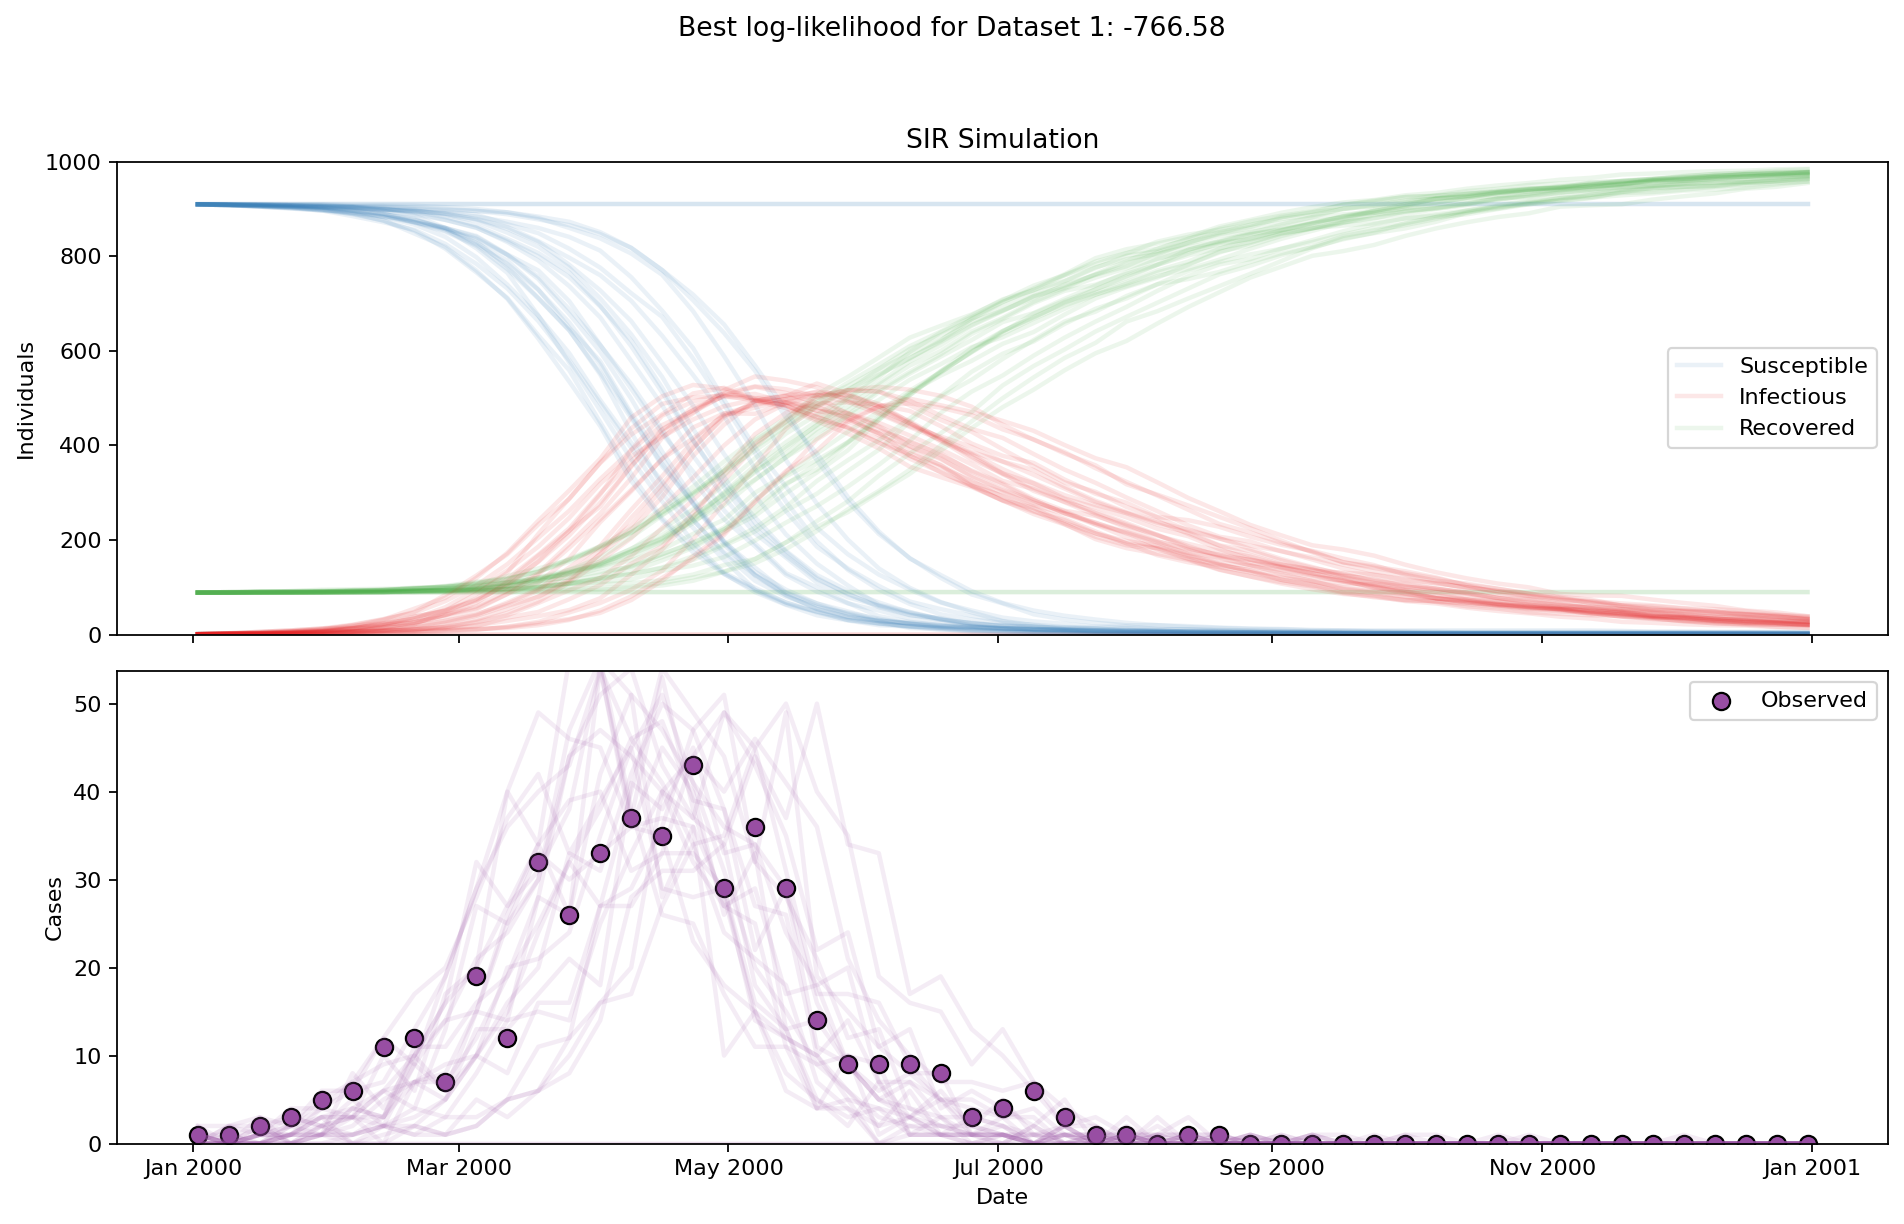

In [7]:
DATASET_NUM = 1

# The initial guess for S_0, beta, gamma, rho
S_0 = logit(910/POPULATION)
beta = np.log(365 / 10)
gamma = np.log(365 / 70)
rho = logit(.45)
initial_guess = np.array([S_0, beta, gamma, rho])

obs_data = load_obs_data(DATASET_NUM)
# error(pars=initial_guess, obs_data=load_obs_data(1))
opt_result_x = run_optimization(
    initial_guess=initial_guess,
    obs_data=obs_data,
    dataset_num=DATASET_NUM, 
    # repeat_opt=5,
)
plot_sir_results(
    opt_result_x=opt_result_x,
    obs_data=obs_data,
    dataset_num=DATASET_NUM,
)

Best parameters for dataset 2: [9.98e+02 3.65e+02 1.46e+01 4.50e-01]
Log-likelihood: -1143.797004553138
Optimization success: True


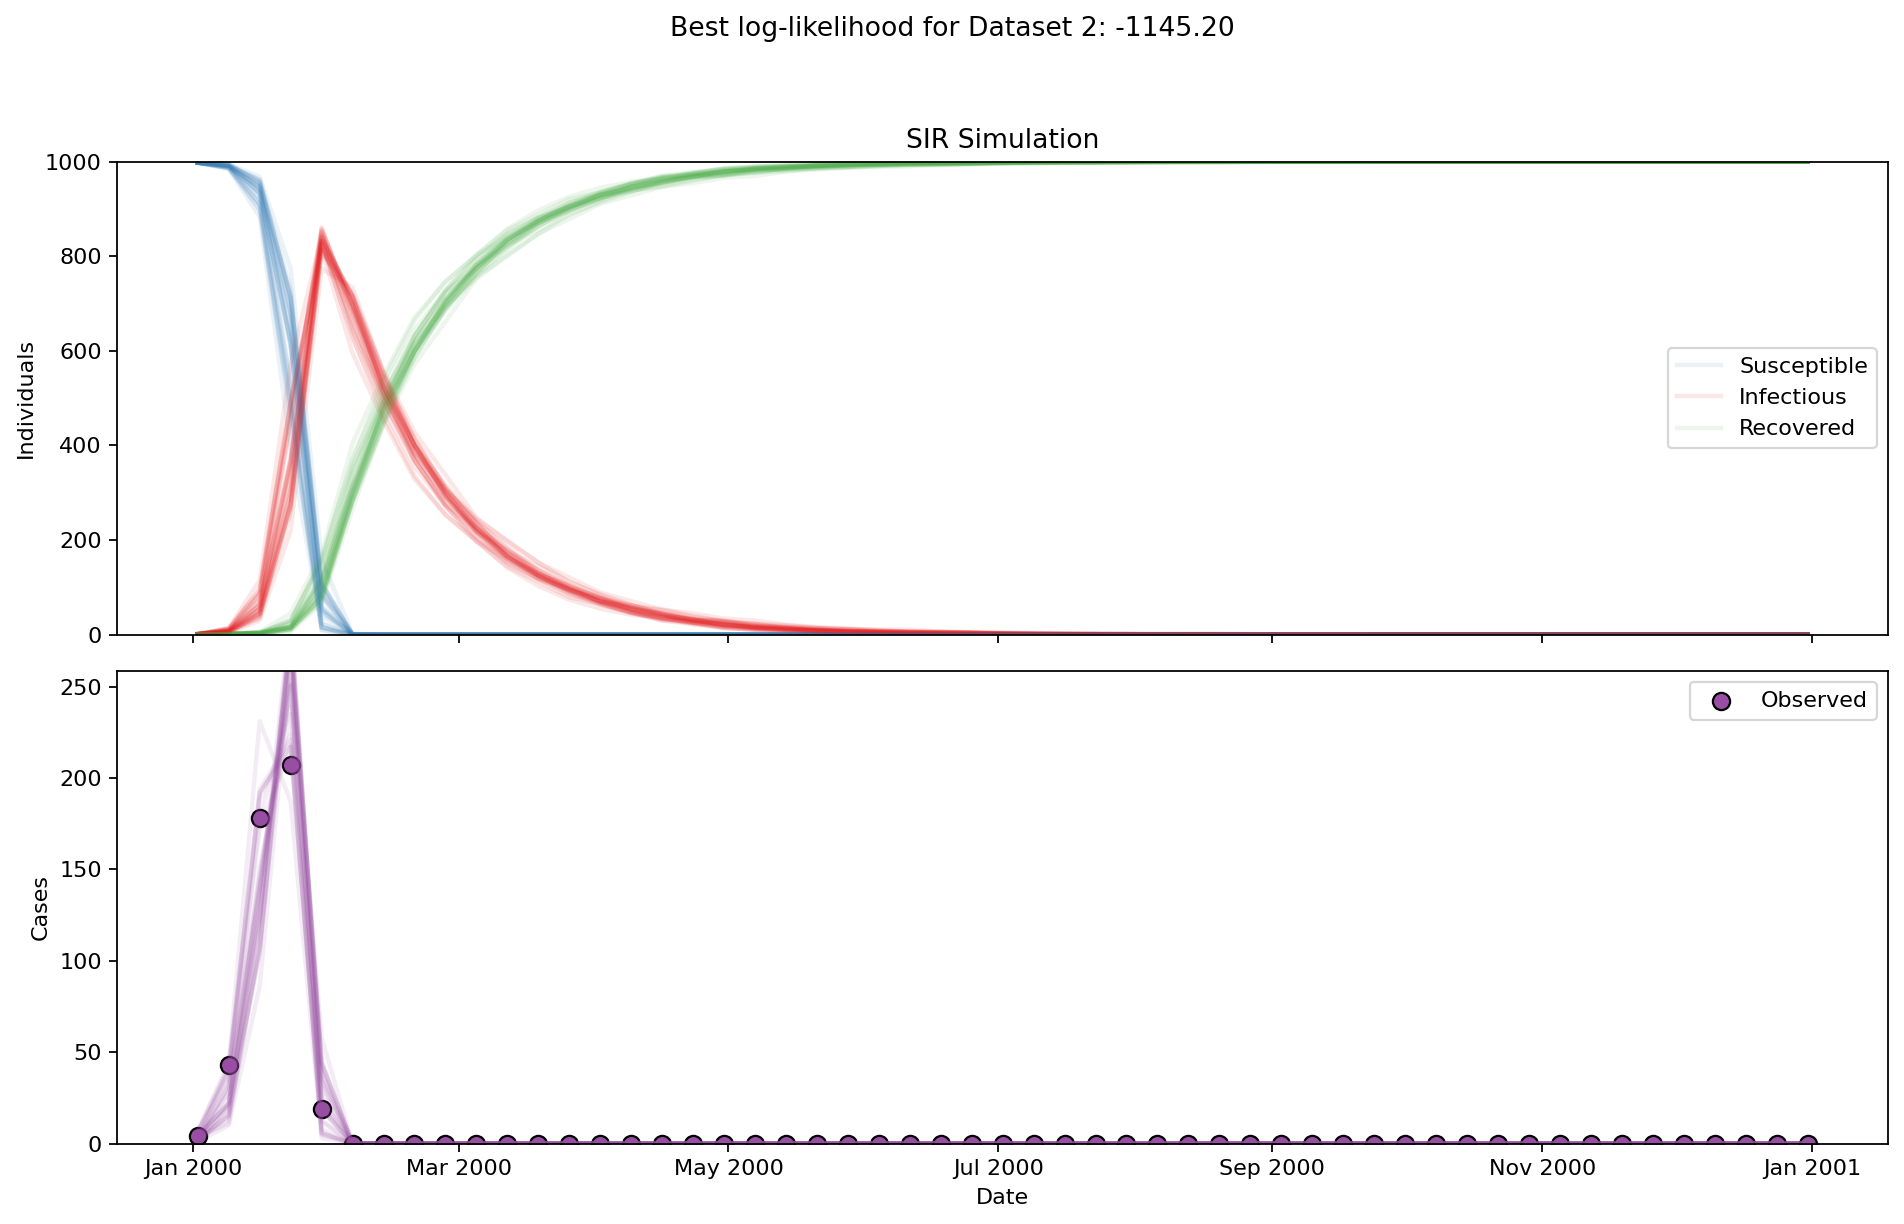

In [8]:
DATASET_NUM = 2

# The initial guess for S_0, beta, gamma, rho
S_0 = logit(999/POPULATION)
beta = np.log(365 / 1)
gamma = np.log(365 / 25)
rho = logit(.45)
initial_guess = np.array([S_0, beta, gamma, rho])

obs_data = load_obs_data(DATASET_NUM)
# error(pars=initial_guess, obs_data=load_obs_data(1))
opt_result_x = run_optimization(
    initial_guess=initial_guess,
    obs_data=obs_data,
    dataset_num=DATASET_NUM, 
    # repeat_opt=5,
)
plot_sir_results(
    opt_result_x=opt_result_x,
    obs_data=obs_data,
    dataset_num=DATASET_NUM,
)

Best parameters for dataset 3: [7.50000000e+02 6.08333333e+01 5.21428849e+00 1.50000000e-01]
Log-likelihood: -1220.3700992868437
Optimization success: False


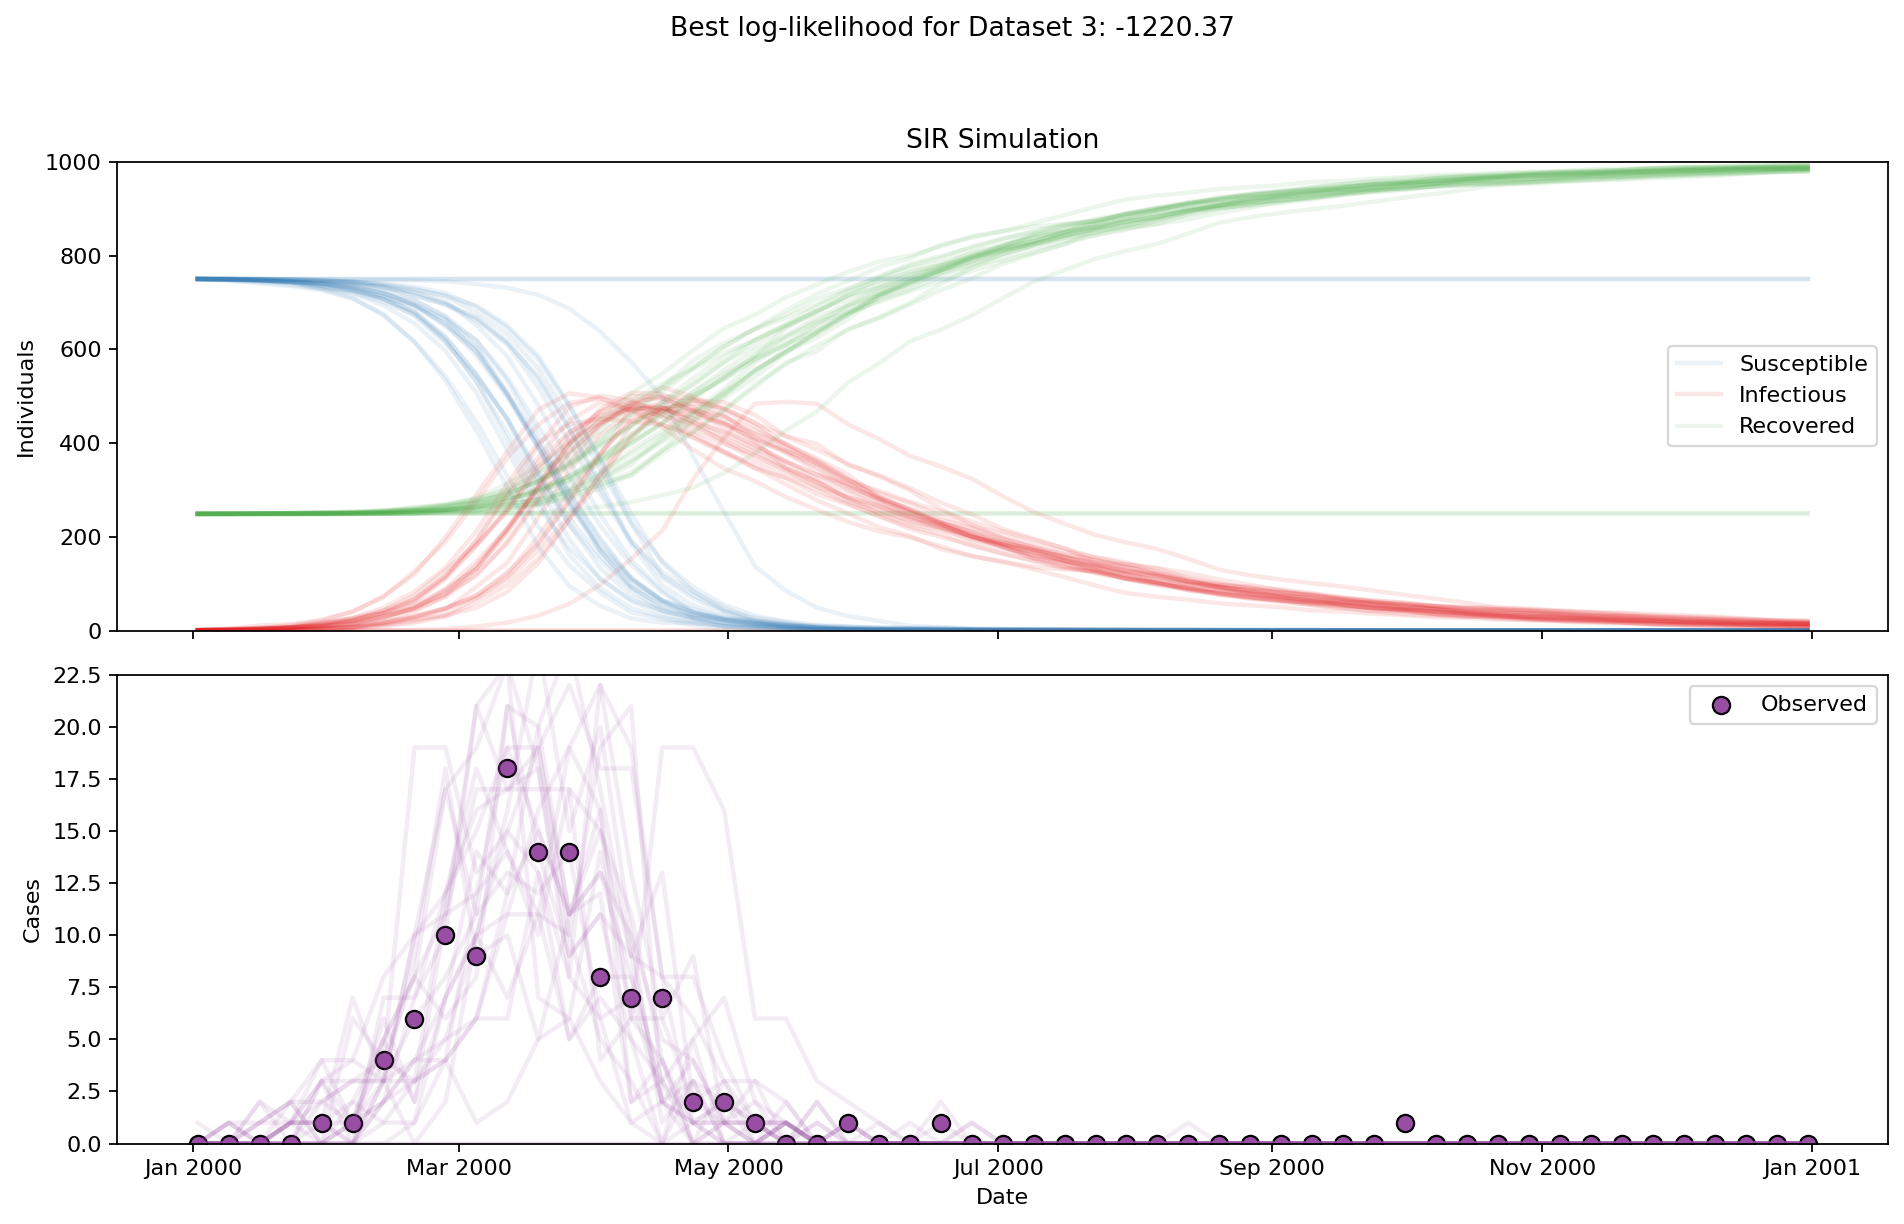

In [9]:
DATASET_NUM = 3

# The initial guess for S_0, beta, gamma, rho
S_0 = logit(750/POPULATION)
beta = np.log(365 / 6)
gamma = np.log(365 / 70)
rho = logit(.15)
initial_guess = np.array([S_0, beta, gamma, rho])

obs_data = load_obs_data(DATASET_NUM)
# error(pars=initial_guess, obs_data=load_obs_data(1))
opt_result_x = run_optimization(
    initial_guess=initial_guess,
    obs_data=obs_data,
    dataset_num=DATASET_NUM, 
    repeat_opt=5,
)
plot_sir_results(
    opt_result_x=opt_result_x,
    obs_data=obs_data,
    dataset_num=DATASET_NUM,
)